<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-5/blob/main/colorization_Rioja_Memoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Colorization
======
We show image colorization as an example of an image-to-image application of CNNs. For practicality, we only experiment on CIFAR. A lot of approaches can be taken to improve the results over the straight-forward implementation in this notebook:

* [*Let there be Color!*](http://hi.cs.waseda.ac.jp/~iizuka/projects/colorization/en/), Iizuka et al., 2016
* [*Colorful Image Colorization*](http://richzhang.github.io/colorization/), Zhang et al. 2016
* [*Learning Representations for Automatic Colorization*](https://arxiv.org/abs/1603.06668), Larsson et al., 2016
* [*Real-Time User-Guided Image Colorization with Learned Deep Priors*](https://richzhang.github.io/ideepcolor/), Zhang et al. 2017


Parameter Settings
-------------------


In [1]:
num_epochs = 50
batch_size = 512
learning_rate = 1e-3
use_gpu = True

CIFAR Data Loading
-------------------

The CIFAR dataset contains 60000 32x32 colour images, split into 50000 training images and 10000 test images. Each image is labeled as one of either 10 (CIFAR10) or 100 (CIFAR100) classes, but we are not using the labels here.

In [2]:
import numpy as np
from skimage import color
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


Color Regressor Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [3]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) # out: 2 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x

cnet = ColorNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
cnet = cnet.to(device)

num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 773698


Train Color Regressor
--------


In [4]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)

# set to training mode
cnet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for lab_batch, _ in train_dataloader:
        
        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
        
        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 174.470547
Epoch [2 / 50] average reconstruction error: 155.183764
Epoch [3 / 50] average reconstruction error: 150.293967
Epoch [4 / 50] average reconstruction error: 146.537197
Epoch [5 / 50] average reconstruction error: 142.677551
Epoch [6 / 50] average reconstruction error: 138.834039
Epoch [7 / 50] average reconstruction error: 133.434592
Epoch [8 / 50] average reconstruction error: 127.896642
Epoch [9 / 50] average reconstruction error: 121.896333
Epoch [10 / 50] average reconstruction error: 115.480557
Epoch [11 / 50] average reconstruction error: 108.818886
Epoch [12 / 50] average reconstruction error: 103.451949
Epoch [13 / 50] average reconstruction error: 97.690660
Epoch [14 / 50] average reconstruction error: 92.902505
Epoch [15 / 50] average reconstruction error: 88.247778
Epoch [16 / 50] average reconstruction error: 84.457098
Epoch [17 / 50] average reconstruction error: 80.826080
Epoch [18 / 50] average reconstr

Plot Training Curves
--------------------

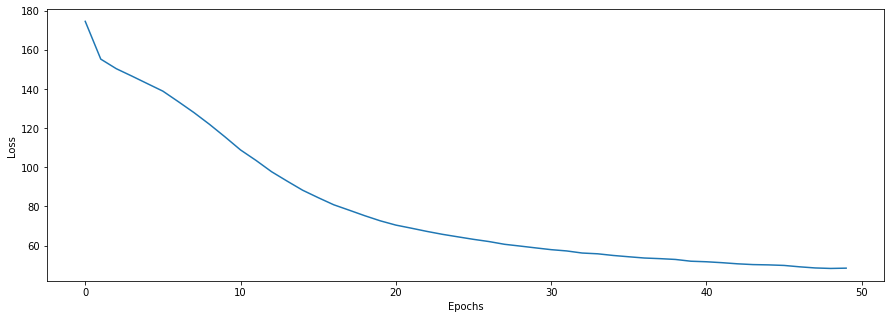

In [5]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Alternatively: Load Pre-Trained Color Regressor
-----------------------------

In [6]:
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/color_net.pth", "./pretrained/color_net.pth")
cnet.load_state_dict(torch.load('./pretrained/color_net.pth'))
print('done')

# this is how the model parameters can be saved:
# torch.save(cnet.state_dict(), './pretrained/my_color_net.pth')

downloading ...
done


Evaluate on the Test Set
----------------------------

In [7]:
# set to evaluation mode
cnet.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, _ in test_dataloader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 184.705190


Show Random Re-Colored Images from the Test Set
-------------------------------------------------
Since our network is relatively simple and small, it still makes a lot of errors, but things like sky, water and background vegetation usually get a plausible color. Correctly coloring details on various objects would require a network with more parameters and for really good results at higher resolutions, some additional tricks need to be applied, as described in the papers linked at the beginning.

In [11]:
!wget https://www.dropbox.com/s/h16ryva1u6k47yf/riojamemoria2AhoraConMenosFotos.zip?dl=0 -O riojaMemoria.zip

--2021-05-30 21:41:18--  https://www.dropbox.com/s/h16ryva1u6k47yf/riojamemoria2AhoraConMenosFotos.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h16ryva1u6k47yf/riojamemoria2AhoraConMenosFotos.zip [following]
--2021-05-30 21:41:19--  https://www.dropbox.com/s/raw/h16ryva1u6k47yf/riojamemoria2AhoraConMenosFotos.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1fb5d7cfc4d914a18c0037287d.dl.dropboxusercontent.com/cd/0/inline/BPedhH4Qqn_08vhCfwHABQvIL4zdTqZZGZM08sM9aGuW_5kF0iKlOH60iYaQ_P_pepbLWe-bLt9j0SnTmceZxn0wE4-E1NZltOvFkM111umc6fRwFjYBFNjOgaR4oVb_Qvg_oLCJsT-2unitPNpjP9BA/file# [following]
--2021-05-30 21:41:19--  https://uc1fb5d7cfc4d914a18c0037287d.dl.dropboxusercontent.com/cd/0/inline/BPedhH4Qqn_08vhC

In [12]:
!unzip riojaMemoria.zip

Archive:  riojaMemoria.zip
   creating: riojamemoria2AhoraConMenosFotos/
  inflating: riojamemoria2AhoraConMenosFotos/125.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/146.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/184.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/185.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/186.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/190.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/191.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/192.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/193.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/194.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/195.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/196.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/197.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/198.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/199.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/200.jpg  
  inflating: riojamemoria2AhoraConMenosFotos/20

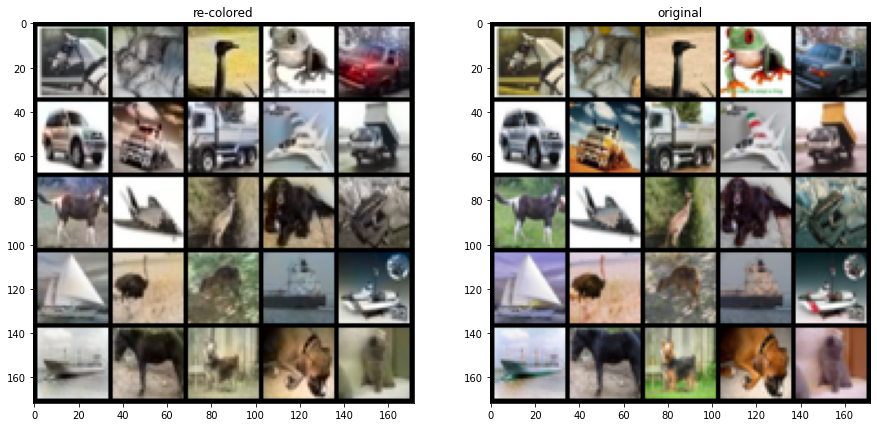

In [8]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(test_dataset), 25, replace=False)
    lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()
